In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest


In [2]:
df = pd.read_csv('data/advertising_data_clean.csv')
df.head()


,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,2,interest,184320,0.0,iOS,search,1.5
1,3,interest,171761,0.0,iOS,search,1.5
2,4,interest,198271,0.0,Android,organic_traffic,0.0
3,5,consideration,202361,0.0,iOS,organic_traffic,0.0
4,5,interest,197181,0.0,Android,organic_traffic,0.0


In [3]:
# Save organic traffic data to a separate dataframe
organic_df = df.loc[df['ad_channel'] == 'organic_traffic']
org_funnel = organic_df.groupby(['funnel_stage']).agg(
    {'user_id': 'count'}).sort_values('user_id', ascending=False).reset_index()
# Add a column for the percentage of users in each funnel stage
org_funnel['percent'] = round(
    org_funnel['user_id'] / org_funnel['user_id'].max() * 100, 1)
org_funnel


,funnel_stage,user_id,percent
0,interest,78065,100.0
1,consideration,53592,68.7
2,intent,9095,11.7
3,purchase,542,0.7


In [4]:
# Save advertising traffic data to a separate dataframe
advertising_df = df.loc[df['ad_channel'] != 'organic_traffic']
adv_funnel = advertising_df.groupby(['funnel_stage']).agg(
    {'user_id': 'count'}).sort_values('user_id', ascending=False).reset_index()
# Add a column for the percentage of users in each funnel stage
adv_funnel['percent'] = round(
    adv_funnel['user_id'] / adv_funnel['user_id'].max() * 100, 1)
adv_funnel


,funnel_stage,user_id,percent
0,interest,505047,100.0
1,consideration,284695,56.4
2,intent,40884,8.1
3,purchase,4292,0.8


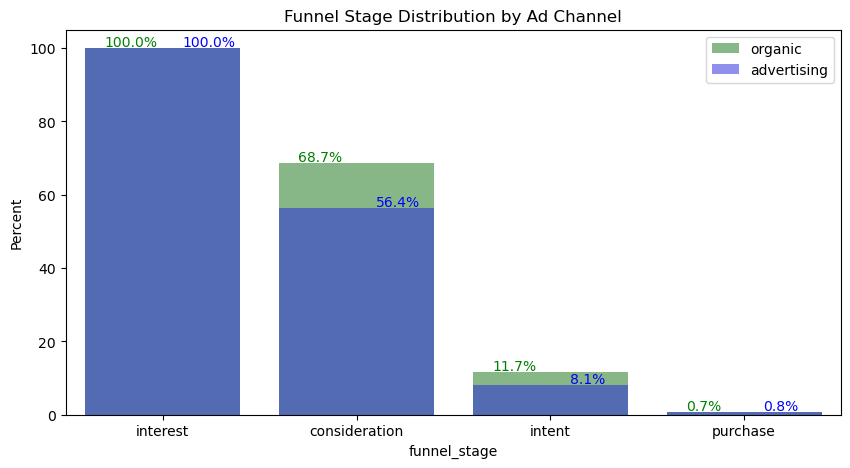

In [13]:
# Plot the two funnel stage distributions on the same chart
plt.figure(figsize=(10, 5))
sns.barplot(x='funnel_stage', y='percent', data=org_funnel,
            color='green', alpha=0.5, label='organic')
sns.barplot(x='funnel_stage', y='percent', data=adv_funnel,
            color='blue', alpha=0.5, label='advertising')
plt.legend()
plt.title('Funnel Stage Distribution by Ad Channel')
plt.ylabel('Percent')
# Add labels to the bars
for i in range(len(org_funnel)):
    plt.text(x=i-0.3, y=org_funnel['percent'][i]+0.5,
             s=f"{org_funnel['percent'][i]}%", color='green')
for i in range(len(adv_funnel)):
    plt.text(x=i+0.1, y=adv_funnel['percent'][i]+0.5,
             s=f"{adv_funnel['percent'][i]}%", color='blue')
plt.show()


### Hypothesis that conversion to purchase is the same for organic and paid traffic
#### H0: Conversion to purchase is the same for organic and paid traffic
#### H1: Conversion to purchase is different for organic and paid traffic

In [30]:
# Significance level 5%
# Critical area two-sided

# Save the number of users at each stage of the funnel
adv_count = adv_funnel.user_id.values[1:4]
org_count = org_funnel.user_id.values[1:4]
nobs = adv_funnel.user_id[0], org_funnel.user_id[0]

# Ztest for equality of shares for each stage of the funnel
for adv, org in zip(adv_count, org_count):
    count = adv, org
    stat, p_value = proportions_ztest(count, nobs)
    nobs = count
    print(f'stat = {stat}, p_value = {p_value}')


stat = -64.70159087700598, p_value = 0.0
stat = -15.621823119499396, p_value = 5.1705786428090794e-55
stat = 13.244722205622812, p_value = 4.840696387617436e-40


At all stages, p_value < 0.05, so we reject the null hypothesis of equal conversion to purchase for organic and paid traffic

In [31]:
# Replace the names of the funnel stages with numbers for convenience
df['funnel_stage'] = df['funnel_stage'].map(
    {'interest': 1, 'consideration': 2, 'intent': 3, 'purchase': 4})

In [32]:
# Number of users at each stage of the funnel for each channel
funnel_by_channel = df.groupby(['ad_channel', 'funnel_stage']).agg({
    'user_id': 'count'}).reset_index()

# Percentage of users at each stage of the funnel for each channel
funnel_by_channel['percent_by_channel'] = round(
    funnel_by_channel['user_id'] / funnel_by_channel.groupby('ad_channel')['user_id'].transform('max') * 100, 2)

# Percentage of users at each stage of the funnel out of the total number of users for each channel
funnel_by_channel['percent_total'] = round(
    funnel_by_channel['user_id'] / len(df) * 100, 4)
funnel_by_channel


,ad_channel,funnel_stage,user_id,percent_by_channel,percent_total
0,banner,1,91282,100.00,9.3506
1,banner,2,47540,52.08,4.8698
2,banner,3,7566,8.29,0.7750
3,banner,4,688,0.75,0.0705
4,native,1,19229,100.00,1.9698
5,native,2,12597,65.51,1.2904
6,native,3,409,2.13,0.0419
7,native,4,37,0.19,0.0038
8,organic_traffic,1,78065,100.00,7.9967
9,organic_traffic,2,53592,68.65,5.4898


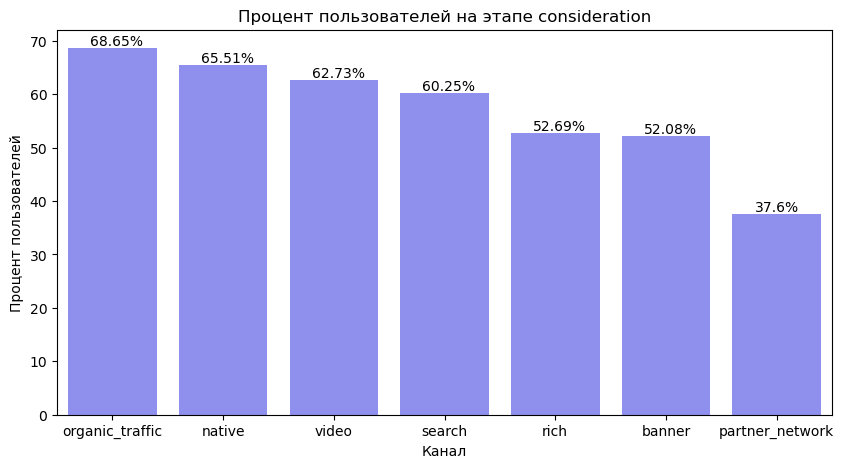

In [33]:
# Pivot table, where the values ​​are the percentage of users at each stage of the funnel for each channel
funnel_by_channel_pivot = funnel_by_channel.pivot(
    index='ad_channel', columns='funnel_stage', values='percent_by_channel')

# Sort by descending percentage of users at the consideration stage
funnel_by_channel_pivot = funnel_by_channel_pivot.sort_values(
    2, ascending=False)

# Graph for stage 2 of the funnel
plt.figure(figsize=(10, 5))
sns.barplot(x=funnel_by_channel_pivot.index,
            y=funnel_by_channel_pivot[2], color='blue', alpha=0.5)
plt.title('Percentage of users at the consideration stage for each channel')
plt.xlabel('Channel')
plt.ylabel('Percent')
# Captions to columns
for i in range(len(funnel_by_channel_pivot)):
    plt.text(x=i-0.2, y=funnel_by_channel_pivot[2]
             [i]+0.5, s=f"{funnel_by_channel_pivot[2][i]}%")
plt.show()


##### Best: organic_traffic - 68.65% и native - 65.51% #
##### Worst: partner_network - 37.6% #

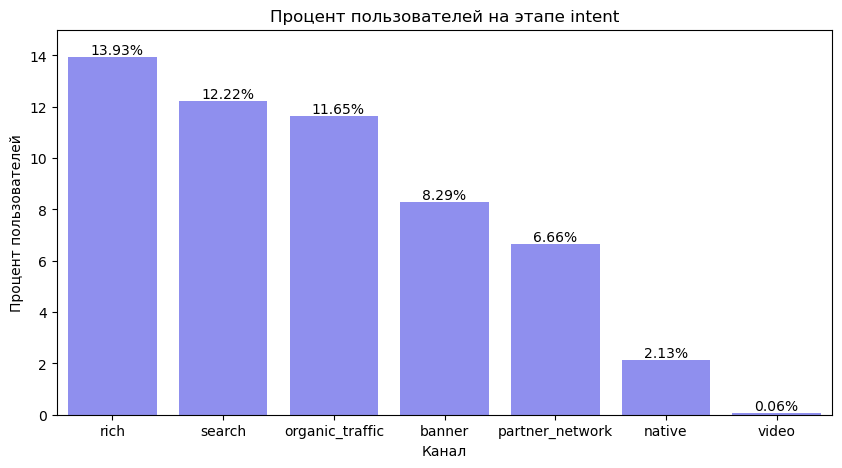

In [34]:
# Sort by descending percentage of users at the intent stage
funnel_by_channel_pivot = funnel_by_channel_pivot.sort_values(
    3, ascending=False)

# Graph for stage 3 of the funnel
plt.figure(figsize=(10, 5))
sns.barplot(x=funnel_by_channel_pivot.index,
            y=funnel_by_channel_pivot[3], color='blue', alpha=0.5)
plt.title('Percentage of users at the intent stage for each channel')
plt.xlabel('Channel')
plt.ylabel('Percent')
plt.ylim(0, 15)
# Captions to columns
for i in range(len(funnel_by_channel_pivot)):
    plt.text(x=i-0.2, y=funnel_by_channel_pivot[3]
             [i]+0.1, s=f"{funnel_by_channel_pivot[3][i]}%")
plt.show()


##### Best: rich - 13.93% #
##### Worst: video - 0.06% #

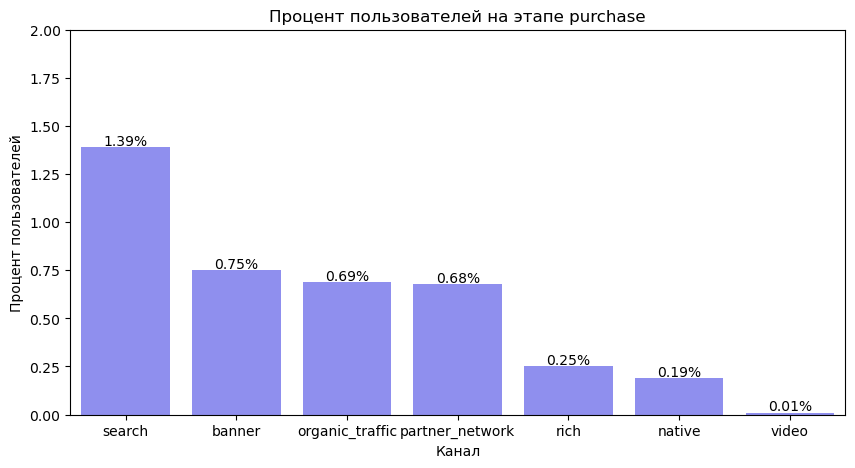

In [35]:
# Sort by descending percentage of users at the purchase stage
funnel_by_channel_pivot = funnel_by_channel_pivot.sort_values(
    4, ascending=False)

# Graph for stage 4 of the funnel
plt.figure(figsize=(10, 5))
sns.barplot(x=funnel_by_channel_pivot.index,
            y=funnel_by_channel_pivot[4], color='blue', alpha=0.5)
plt.title('Процент пользователей на этапе purchase')
plt.xlabel('Канал')
plt.ylabel('Процент пользователей')
plt.ylim(0, 2)
# Captions to columns
for i in range(len(funnel_by_channel_pivot)):
    plt.text(x=i-0.2, y=funnel_by_channel_pivot[4]
             [i]+0.01, s=f"{funnel_by_channel_pivot[4][i]}%")
plt.show()


##### Best: search - 1.39% #
##### Worst: video - 0.01% #


## Conclusions:

Based on observations, we can assume that the video channel is the least efficient channel and should be disabled. It has low conversion rates at stages 3 and 4 of the funnel, which indicates its low effectiveness in attracting users. Disabling it will allow us to redistribute impressions to other channels, which will potentially increase sales.

The search channel is an ideal choice for redistributing impressions, because it shows undoubted advantages. It consistently demonstrates high conversion rates at every stage of the sales funnel. It achieves especially impressive results at the final stage - the conversion to purchase is twice as high as the results of its closest competitor.